In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Загрузка и предобработка данных

In [2]:
df = pd.read_table('data_banknote_authentication.txt', sep= ',', names= ['variance','skewness','curtosis','entropy','class'])
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


Датасет представляет из себя результаты графического анализа подлинных и поддельных банкнот (целевая переменная class). В ходе анализа были получены 4 предиктора - различные характеристики изображения банкноты

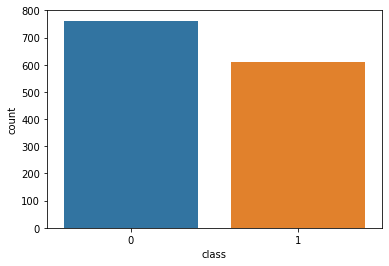

In [3]:
sns.countplot(x='class',data=df)

In [4]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [5]:
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['class'], axis=1), 
    df['class'], 
    test_size=0.30, 
    random_state=42, 
    stratify=df['class']
)

In [7]:
n_estimators = 20
max_depth = 3
learning_rate = 0.1

In [8]:
def plot_confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data = cm)
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap="YlGnBu",
                cbar=False,
                xticklabels = ['Actual_true','Actual_false'],
                yticklabels = ['Predict_true','Predict_false']);

In [9]:
def quality_report(actual, prediction):

    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    
    print("\n=== Quality Report ===")
    print(f'Accuracy: \t{acc:.4f}',
          f'Precision: \t{precision:.4f}',
          f'Recall: \t{recall:.4f}',
          f'f1_score: \t{f1:.4f}',
          sep = '\n')
    print("======================\n")

# Sklearn


=== Quality Report ===
Accuracy: 	0.9709
Precision: 	0.9891
Recall: 	0.9476
f1_score: 	0.9679



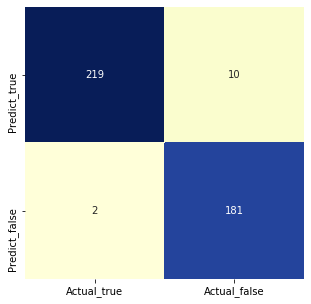

In [10]:
skl_gb = GradientBoostingClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate)
skl_gb.fit(X_train, y_train)
pred_skl = skl_gb.predict(X_test)
quality_report(y_test, pred_skl)
plot_confusion(y_test, pred_skl)

# XGboost


=== Quality Report ===
Accuracy: 	0.9709
Precision: 	0.9891
Recall: 	0.9476
f1_score: 	0.9679



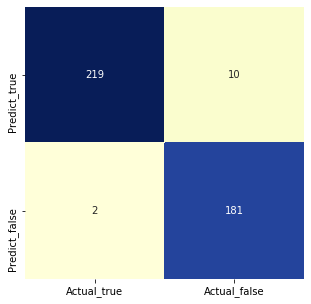

In [11]:
xgb_gb = xgb.XGBClassifier(n_estimators=n_estimators,
                           max_depth=max_depth,
                           learning_rate=learning_rate)
xgb_gb.fit(X_train, y_train)
pred_xgb = xgb_gb.predict(X_test)
quality_report(y_test, pred_xgb)
plot_confusion(y_test, pred_xgb)

# CatBoost


=== Quality Report ===
Accuracy: 	0.9709
Precision: 	0.9891
Recall: 	0.9476
f1_score: 	0.9679



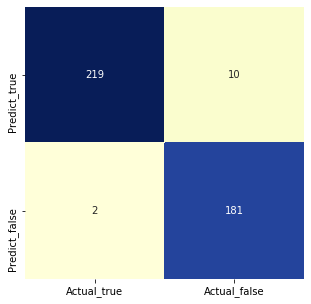

In [12]:
cb_gb = CatBoostClassifier(iterations=n_estimators,
                           depth=max_depth,
                           learning_rate=learning_rate,
                           verbose=False)
cb_gb.fit(X_train, y_train)
pred_xgb = xgb_gb.predict(X_test)
quality_report(y_test, pred_xgb)
plot_confusion(y_test, pred_xgb)

# Подбор параметров

Подберём с помощью гридсёрч оптимальные параметры модели и проверим на тестовой выборке результативность 

Sklearn:

In [13]:
params = {'n_estimators': range(50, 100, 5), 
          'max_depth': range(2, 10),
          'learning_rate': np.arange(0.1, 0.3, 0.05)}

Лучшие параметры: {'learning_rate': 0.25000000000000006, 'max_depth': 2, 'n_estimators': 85}

=== Quality Report ===
Accuracy: 	0.9976
Precision: 	1.0000
Recall: 	0.9946
f1_score: 	0.9973



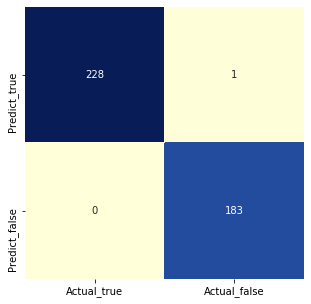

In [14]:
grid = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=params, cv=5, scoring= 'f1')
grid = grid.fit(X_train, y_train)
print(f'Лучшие параметры: {grid.best_params_}')
skl_gb = grid.best_estimator_
skl_gb.fit(X_train, y_train)
pred_skl = skl_gb.predict(X_test)
quality_report(y_test, pred_skl)
plot_confusion(y_test, pred_skl)

XGboost:

Лучшие параметры: {'learning_rate': 0.25000000000000006, 'max_depth': 2, 'n_estimators': 90}

=== Quality Report ===
Accuracy: 	0.9951
Precision: 	1.0000
Recall: 	0.9892
f1_score: 	0.9946



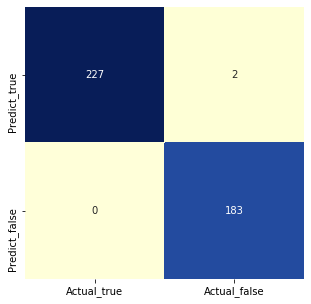

In [15]:
grid = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=params, cv=5, scoring= 'f1')
grid = grid.fit(X_train, y_train)
print(f'Лучшие параметры: {grid.best_params_}')
skl_gb = grid.best_estimator_
skl_gb.fit(X_train, y_train)
pred_skl = skl_gb.predict(X_test)
quality_report(y_test, pred_skl)
plot_confusion(y_test, pred_skl)

CatBoost:

Лучшие параметры: {'learning_rate': 0.15000000000000002, 'max_depth': 9, 'n_estimators': 75}

=== Quality Report ===
Accuracy: 	0.9976
Precision: 	1.0000
Recall: 	0.9946
f1_score: 	0.9973



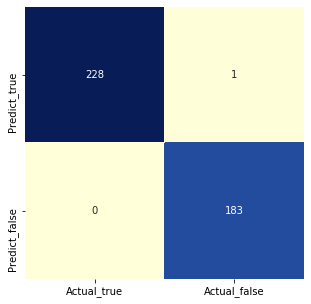

In [16]:
grid = GridSearchCV(estimator=CatBoostClassifier(verbose=False), param_grid=params, cv=5, scoring= 'f1')
grid = grid.fit(X_train, y_train)
print(f'Лучшие параметры: {grid.best_params_}')
skl_gb = grid.best_estimator_
skl_gb.fit(X_train, y_train)
pred_skl = skl_gb.predict(X_test)
quality_report(y_test, pred_skl)
plot_confusion(y_test, pred_skl)